In [ ]:
from OSMPythonTools.nominatim import Nominatim
from pathlib import Path
import pandas as pd
import re

df = pd.read_csv("../datasets/Faramacie_temp.csv", sep=";")
nominatim = Nominatim()
results = []

LAT = []
LON = []

for via, citta in zip(df["INDIRIZZO"], df["DESCRIZIONECOMUNE"]):

    via = str(via).lower().replace('a\'', 'a').replace('e\'', 'e').replace('i\'', 'i').replace('o\'', 'o').replace('u\'', 'u')
    citta = str(citta).lower().replace('a\'', 'a').replace('e\'', 'e').replace('i\'', 'i').replace('o\'', 'o').replace('u\'', 'u')

    res = nominatim.query(via + "," + citta)
    results.append(res)

for item in results:
    tmp = item.toJSON()
    if len(tmp) != 0:
        LAT.append(tmp[0]['lat'])
        LON.append(tmp[0]['lon'])
    else:
        LAT.append(0.0)
        LON.append(0.0)

df["LONGITUDINE"] = pd.Series(LON)
df["LATITUDINE"] = pd.Series(LAT)
#df.insert(loc=0, column='LONGITUDINE', value=pd.Series(LON))
#df.insert(loc=0, column='LATITUDINE', value=pd.Series(LAT))

filepath = Path('../datasets/out.csv')
df.to_csv(filepath, index=False)

In [ ]:
import pandas as pd
from pathlib import Path
farmacie = pd.read_csv("../datasets/pivoted/farmacie.csv", sep=";")
farmacie["LATITUDINE"] = farmacie["LATITUDINE"].apply(lambda x : float(x.replace(',', '.')) if x != '-' else 0.0)
farmacie["LONGITUDINE"] = farmacie["LONGITUDINE"].apply(lambda x : float(x.replace(',', '.')) if x != '-' else 0.0)
farmacie["PARTITAIVA"] = farmacie["PARTITAIVA"].apply(lambda x : x if x != "-" else 0)
farmacie["INDIRIZZO"] = farmacie["INDIRIZZO"].apply(lambda x : x.replace('"', ''))
filepath = Path('../datasets/completed/farmacie.csv')
farmacie.to_csv(filepath, index=False,sep=";")

In [ ]:
import numpy as np
import pandas as pd
farmacie = pd.read_csv("../datasets/completed/farmacie.csv", sep=";")
farmacie.convert_dtypes()
farmacie.dtypes

In [ ]:
df = pd.read_csv("../datasets/out.csv")
df.dtypes
print(df.head())

In [ ]:
import pandas as pd
from pathlib import Path
farmacie = pd.read_csv("../datasets/completed/farmacie.csv", sep=";")
farmacie = farmacie.drop(farmacie.loc[1484:].index)

print(farmacie.head())
df = pd.read_csv("../datasets/out.csv")
df_finale = pd.merge(farmacie,df,how="outer")


In [ ]:
filepath = Path('../datasets/farmacie_new.csv')
df_finale.to_csv(filepath, index=False)

In [ ]:
from OSMPythonTools.nominatim import Nominatim
from pathlib import Path
import pandas as pd
import re

farm = pd.read_csv("56.csv", on_bad_lines="skip", delimiter=",", encoding="utf-8")
farm.columns = farm.columns.str.strip()

nominatim = Nominatim()
results = []

LAT = []
LON = []

for via, cap in zip(farm["INDIRIZZO"], farm["CAP"]):

    via = str(via).lower().replace('a\'', 'a').replace('e\'', 'e').replace('i\'', 'i').replace('o\'', 'o').replace('u\'', 'u')
    cap = str(cap).lower().replace('a\'', 'a').replace('e\'', 'e').replace('i\'', 'i').replace('o\'', 'o').replace('u\'', 'u')

    res = nominatim.query(via + " " + cap)
    results.append(res)

for item in results:
    tmp = item.toJSON()
    if len(tmp) != 0:
        LAT.append(tmp[0]['lat'])
        LON.append(tmp[0]['lon'])
    else:
        LAT.append(0.0)
        LON.append(0.0)
            
farm.insert(loc=0, column='lat', value=pd.Series(LAT))
farm.insert(loc=0, column='long', value=pd.Series(LON))

filepath = Path('farmacie2.csv')
farm.to_csv(filepath, index=False)

In [3]:
from rdflib import *
base_uri = "http://www.sanitasicilia.it/resource/"

g = Graph()

sso = Namespace("http://www.sanitasicilia.it/ontology/")

g.bind("sso", sso)

ssr = Namespace("http://www.sanitasicilia.it/resource/")
g.bind("ssr", ssr)

g.parse('../datasets/rdf/sanitasicilia.xml')


<Graph identifier=N9a2244efd56c469886fcf50f9c7e3ff1 (<class 'rdflib.graph.Graph'>)>

In [7]:

res = g.query(""" 
                SELECT ?name ?lat ?lon
                WHERE {
                    ?res rdf:type sso:Farmacia.
                    ?res sso:hasName ?name.
                    ?res sso:hasSite ?site.
                    ?site sso:hasLatitude ?lat.
                    ?site sso:hasLongitude ?lon.
                }
                """)   


name = [str(i[0]) for i in res]
lat = [float(i[1]) for i in res]
lon = [float(i[2]) for i in res]


print(name[0], lat[0], lon[0]) 

Brancato Calogero 37.256939 13.918198


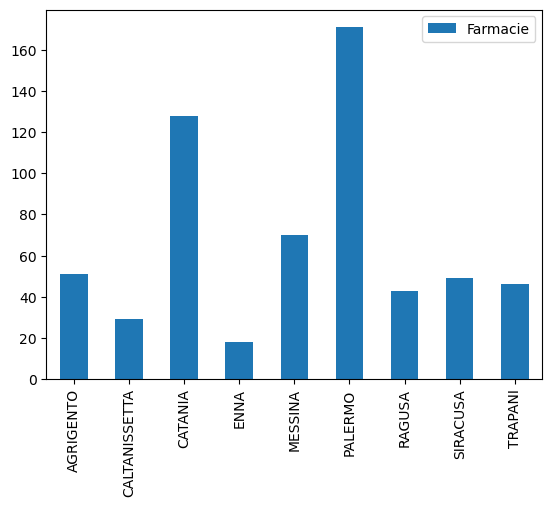

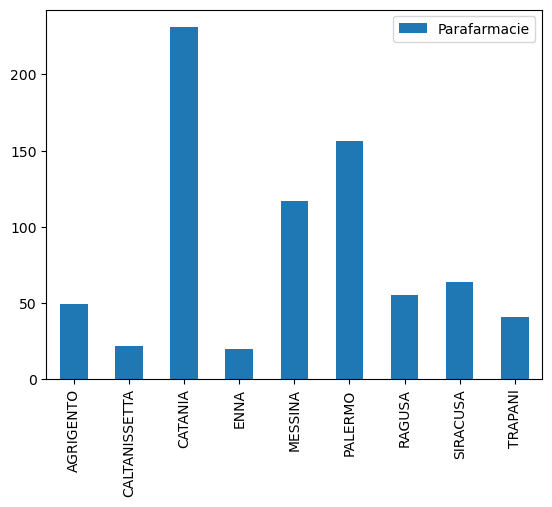

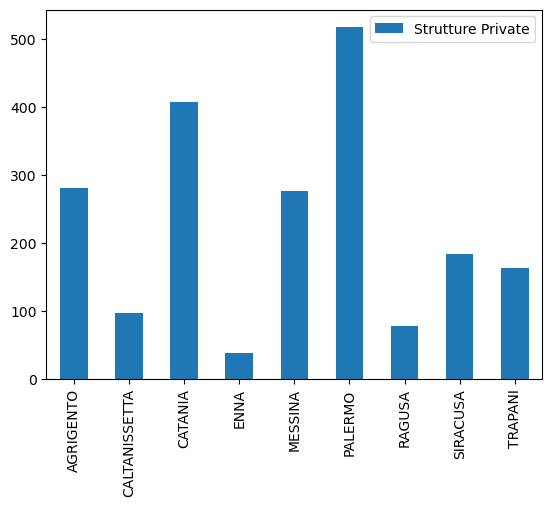

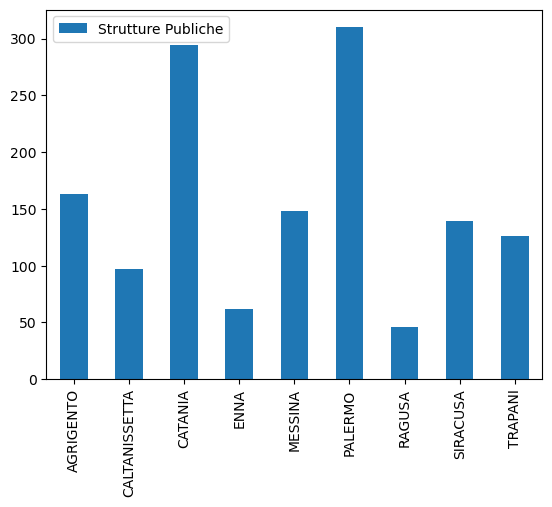

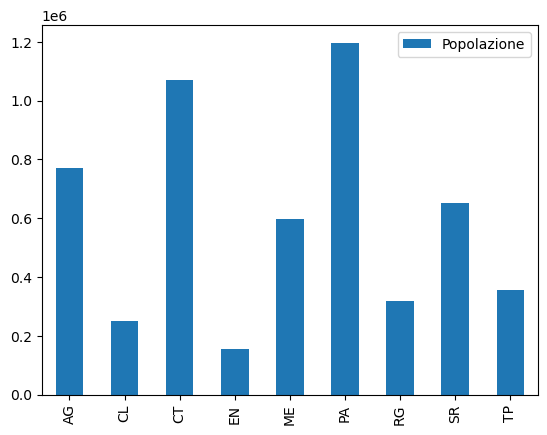

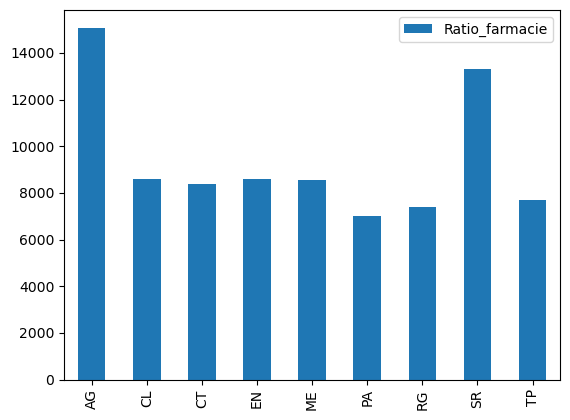

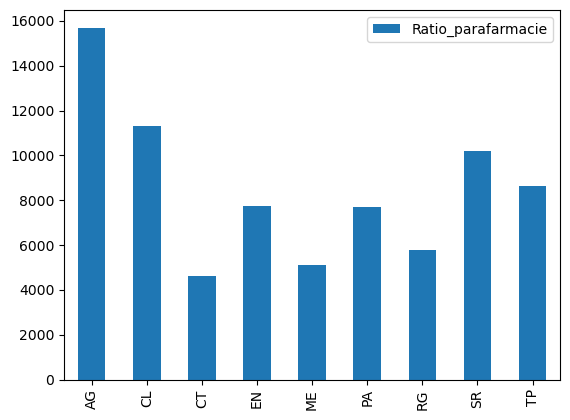

In [18]:
import pandas as pd
# df_farmacie = pd.read_csv("../datasets/csv/completed/farmacie.csv")
# df_parafarmacie = pd.read_csv("../datasets/csv/completed/parafarmacie.csv")
#df_sicilia = pd.read_csv("../datasets/csv/completed/comuni_sicilia.csv")
# df_private = pd.read_csv("../datasets/csv/completed/private.csv")
# df_publiche = pd.read_csv("../datasets/csv/completed/pubbliche.csv")
res = g.query(""" 
            SELECT ?prov (SUM(?pop) AS ?tot)
            WHERE {
                ?res rdf:type sso:Comune .
                ?res sso:hasTotalPopulation ?pop .
                ?res sso:hasProvinceAcr ?prov .
            }
            GROUP BY ?prov
            ORDER BY ASC(?prov)
            """)

provincie = [str(i[0]) for i in res]
population = [int(i[1]) for i in res]
# for i in range(0, len(provincie)):
#     sum = df_sicilia[df_sicilia["Provincia"]== provincie[i]]["PopolazioneTotale"].sum()
#     population.append(sum)

res = g.query(""" 
            SELECT ?prov (COUNT(?res) AS ?count)
            WHERE {
                ?res rdf:type sso:Farmacia .
                ?res sso:hasSite ?site .
                ?site sso:isIn ?comune .
                ?comune sso:hasProvince ?prov .
            }
            GROUP BY ?prov
            ORDER BY ASC(?prov)
            """)

num_farmacie = [int(i[1]) for i in res]
prov_farmacie = [str(i[0]) for i in res]


res = g.query(""" 
            SELECT ?prov (COUNT(?res) AS ?count)
            WHERE {
                ?res rdf:type sso:Parafarmacia .
                ?res sso:hasSite ?site .
                ?site sso:isIn ?comune .
                ?comune sso:hasProvince ?prov .
            }
            GROUP BY ?prov
            ORDER BY ASC(?prov)
            """)

num_parafarmacie = [int(i[1]) for i in res]
prov_parafarmacie = [str(i[0]) for i in res]


res = g.query(""" 
            SELECT ?prov (COUNT(?res) AS ?count)
            WHERE {
                ?res rdf:type sso:StrutturaPrivata .
                ?res sso:hasSite ?site .
                ?site sso:isIn ?comune .
                ?comune sso:hasProvince ?prov .
            }
            GROUP BY ?prov
            ORDER BY ASC(?prov)
            """)

num_private = [int(i[1]) for i in res]
prov_private = [str(i[0]) for i in res]

res = g.query(""" 
            SELECT ?prov (COUNT(?res) AS ?count)
            WHERE {
                ?res rdf:type sso:StrutturaPubblica .
                ?res sso:hasSite ?site .
                ?site sso:isIn ?comune .
                ?comune sso:hasProvince ?prov .
            }
            GROUP BY ?prov
            ORDER BY ASC(?prov)
            """)

num_pubbliche = [int(i[1]) for i in res]
prov_pubbliche = [str(i[0]) for i in res]



ratios_farmacie = []
for i in range(0,len(prov_farmacie)):
    ratio = population[i] / num_farmacie[i]
    ratios_farmacie.append(ratio)

ratios_parafarmacie = []
for i in range(0,len(provincie)):
    ratio = population[i] / num_parafarmacie[i]
    ratios_parafarmacie.append(ratio)

df_finale_farmacie = pd.DataFrame({"Farmacie": num_farmacie}, index=prov_farmacie).plot.bar()
df_finale_parafarmacie = pd.DataFrame({"Parafarmacie": num_parafarmacie}, index=prov_parafarmacie).plot.bar()
df_finale_private = pd.DataFrame({"Strutture Private": num_private}, index=prov_private).plot.bar()
df_finale_publiche = pd.DataFrame({"Strutture Publiche": num_pubbliche}, index=prov_pubbliche).plot.bar()
df_finale_popolazione = pd.DataFrame({"Popolazione": population}, index=provincie).plot.bar()
df_finale_ratio_farmacie = pd.DataFrame({"Ratio_farmacie": ratios_farmacie}, index=provincie).plot.bar()
df_finale_ratio_parafarmacie = pd.DataFrame({"Ratio_parafarmacie": ratios_parafarmacie}, index=provincie).plot.bar()




In [5]:
df_private[df_private["Provincia"]==provincie[0]]

,CAP,Latitudine,Longitudine,ASP,Provincia,Citta',Indirizzo,Denominazione,Attivita',Tipo sede
